In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import tifffile

In [2]:
import pre_process_mm as pre
import mm3_adapted_cell_segmentation as mm3seg
import mm3_adapted_cell_tracking as mm3track

# Correct for image drift and rotation

In [ ]:
# Specify experiment folder with aquired positions, default output from Covert lab scope's micromanager
root_dir = '/Users/noravivancogonzalez/Desktop/20241114'
# Privide experiment suffix
# Indicate phase channel index
drift_corrected_path = pre.drift_correct(root_dir, 'DuMM', c=0)

In [3]:
drift_corrected_path = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected'

Cropping reference image
-1.0046174103583552
Cropping reference image
-0.9040020324470418


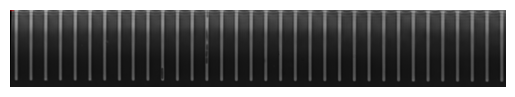

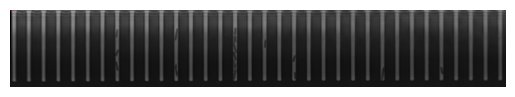

Successfully rotated stack


In [5]:
# Growth channel length depends on # of pixels, measure on image for proper estimation
path_to_rotated_images = pre.rotate_stack(drift_corrected_path, c=0, growth_channel_length=400)

# Isolate microfluidic channels

channels identified in FOV 009
saving sliced microfluidic channels as tcyx stacks
channels identified in FOV 001
saving sliced microfluidic channels as tcyx stacks


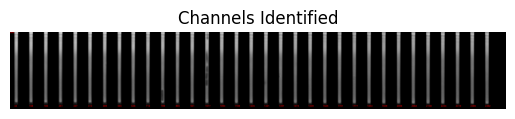

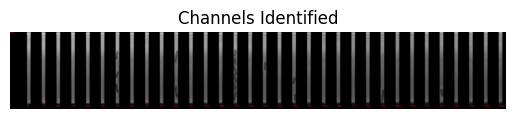

In [14]:
# Separate mother machine channels as individual files
path_to_mm_channels = pre.extract_mm_channels(path_to_rotated_images)

In [12]:
# There are IDs added to each microfluidic channel identified in the image. 
#These images can be found in the mm_channels subfulder and are labeled
# for example as "FOV001_mm_channel_mask.tif"

# Subtract background from phase and fluorescent images

In [7]:
# Continue analysis on specific field of view
FOV = '001'

In [8]:
# Specify the ID numebr of an empty channel to subtract background from phase image
empty_stack_id = '707'

In [9]:
# Specify ID numbers for channels with cells
ana_peak_ids = ['1164', '1314', '2227']

In [10]:
# Indicate what kind of channel to subtract from in method, set to 'phase' or 'fluor' for a fluorescent channel
# Indicate the index of the channel to which subtraction will occur
pre.subtract_fov_stack(path_to_mm_channels, FOV, empty_stack_id, ana_peak_ids, method = 'phase', channel_index= 0)

In [11]:
# Subtract background from fluorescent channel
pre.subtract_fov_stack(path_to_mm_channels, FOV, empty_stack_id, ana_peak_ids, method = 'fluor', channel_index= 1)

# Identify cells in image per microfluidic channel

In [15]:
fov_id = '001'
peak_id = '1164' # '2227' #'1314' 
phase_channel = '0'
fluor_channel = '1'
path_to_phase_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'
path_to_fluor_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/subtracted_FOV_{fov_id}_region_{peak_id}_c_{fluor_channel}.tif'

In [19]:
# Specify a mask output path where labeled masks can be added to further process images with cellTK
output_path = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/outputs'

In [20]:
# This function produces a labeled mask for every time point, which can be used to identify cells
# The parameters for this function are based on # of pixels and whether there is pixel binning
# A section included at the bottom of this notebook indicates how to find the best parameters
mm3seg.segment_chnl_stack(path_to_phase_stack,
						   output_path,
						   OTSU_threshold=1.5,
						   first_opening=5,
						   distance_threshold=3,
						   second_opening_size=1,
						   min_object_size=5) 

In [21]:
labeled_stack = f'/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/mm3_segmented_subtracted_FOV_{fov_id}_region_{peak_id}_c_{phase_channel}.tif'

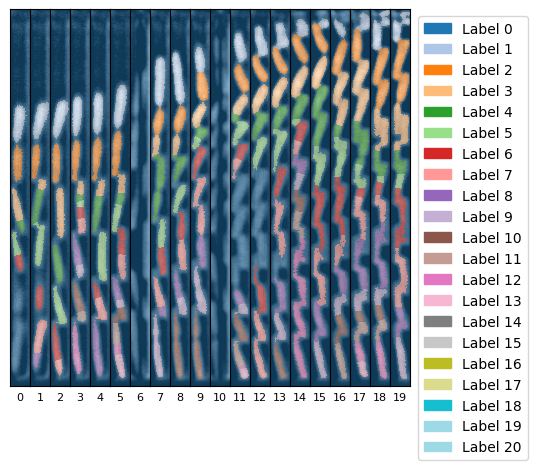

In [23]:
# Plot identified cells in from start timeframe, until timeframe 20 to get a sense of the success of cell segementation
# In this case only some of the segmentation looks of, a lot of cells are stacked at an angle with overlaps, making it difficult for the
# algorithm to distinguish one cell from another.
mm3seg.display_segmentation(path_to_phase_stack, mask_path = labeled_stack, start=0, end=20, alpha=0.5)

In [24]:
# Extract information from identified cells in a dictionary
# This function attempts to identify cells across timeframes, tracking divisions.
# Time between frames can be specified in minutes to create a timeline
# Pixel to micron conversion can also be specified here to determine cell area in microns, otherwise it is reported in pixels
cells_dict = mm3track.make_lineage_chnl_stack(path_to_stack = path_to_phase_stack, 
                                              labeled_stack = labeled_stack, 
                                              fov_id = int(fov_id), 
                                              peak_id = int(peak_id), 
                                              time_btwn_frames =5, pxl2um = 1)

In [25]:
# Extract information on cell fluorescence intensity
mm3track.find_cell_intensities(path_to_fluor_stack, labeled_stack, cells_dict, midline=False)

In [26]:
# Report information from cell dictionary in a pandas datframe
cells_pd = mm3track.cells2df(cells_dict, num_time_frames = 5)

In [27]:
cells_pd.head(3)

,cell_id,fov,peak,birth_label,parent,daughters,birth_time_index,time_index,labels,areas_(pxls^2),lengths_(pxls),widths_(pxls),orientations,centroids,generation time_(min),fl_area_avgs,bb_xLeft,bb_yTop,bb_width,bb_height
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,0,1,329.0,37.125,10.546875,1.453125,"(113.1, 8.37)",45.0,11.352584,96,3,134,17
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,1,1,355.0,38.28125,9.976562,1.296875,"(109.5, 10.055)",45.0,12.614085,93,3,130,19
0,f01p1164t0000r01,1,1164,1,None,"[f01p1164t0009r02, f01p1164t0009r03]",0,2,1,353.0,38.84375,9.820312,1.328125,"(108.0, 9.57)",45.0,10.858357,91,3,130,19


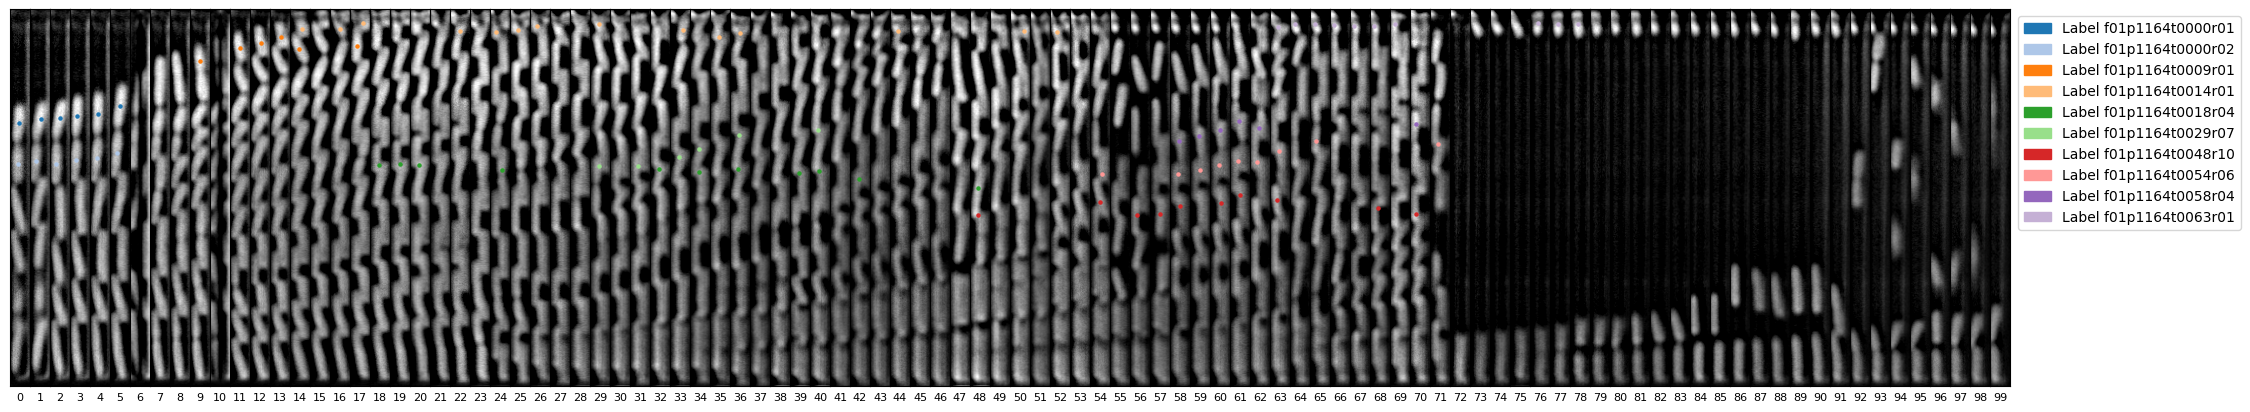

In [28]:
# If mask is not specified but there is cell information in a pandas dataframe, identified centroids can be superimposed on phase image
mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cells_pd, start=0, end=100)

# Analysis of identified cells

In [29]:
def cell_color_dict(cells_df):
    color_dict = {}
    unique_cell_ids = cells_df['cell_id'].unique()
    total_number_labels = len(unique_cell_ids)
    number_of_colors_needed = max(20, total_number_labels)
    # Get a colormap with  distinct colors, for potential cell labels
    cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)
    # Create a dictionary mapping integers to hex color codes
    for color_i, cell_id in enumerate(unique_cell_ids):
        color = cmap(color_i)[:3]  # Extract RGB values
        color_dict[cell_id] = color
    return color_dict

In [30]:
color_dict = cell_color_dict(cells_pd)

/var/folders/hj/bk95lprn3zb88y7bqhjh9j5m0000gr/T/ipykernel_49621/419849173.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', number_of_colors_needed)


Text(0.5, 28.999999999999986, 'Time frames')

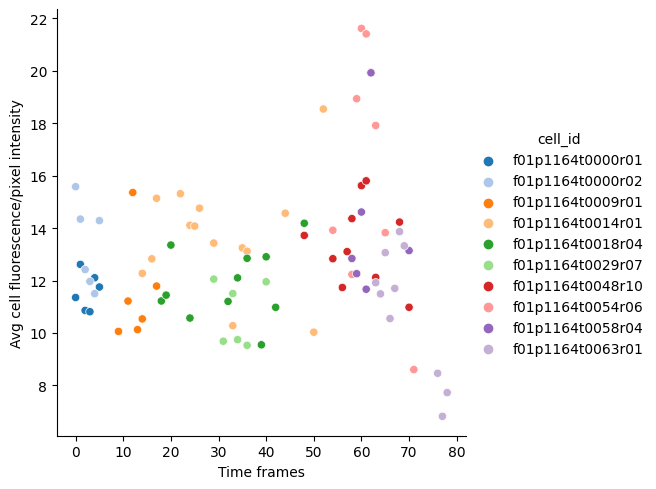

In [31]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'fl_area_avgs', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('Avg cell fluorescence/pixel intensity')
plt.xlabel('Time frames')

Text(0.5, 28.999999999999986, 'Time frames')

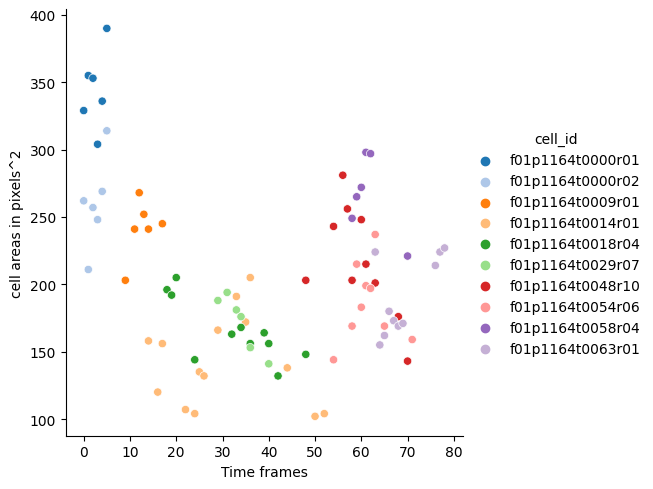

In [32]:
sns.relplot(data=cells_pd, x= 'time_index', y= 'areas_(pxls^2)', hue= 'cell_id', palette = color_dict)

sns.despine()

plt.ylabel('cell areas in pixels^2')
plt.xlabel('Time frames')

In [33]:
# based on the fluoresence intensity plot above we can see that cell 'f01p1164t0054r06' may be demonstrating higher fluorescence expression
# And that is only tracked aroynd timeframes 50-80

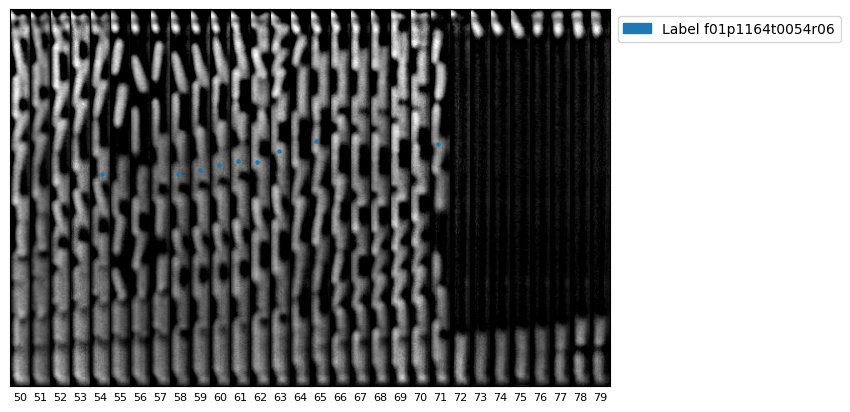

In [35]:
# Track cell 'f01p1164t0054r06'in phase channel
cell_df = cells_pd[cells_pd['cell_id'].isin(['f01p1164t0054r06'])] 
mm3seg.display_segmentation(path_to_phase_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=50, end=80)

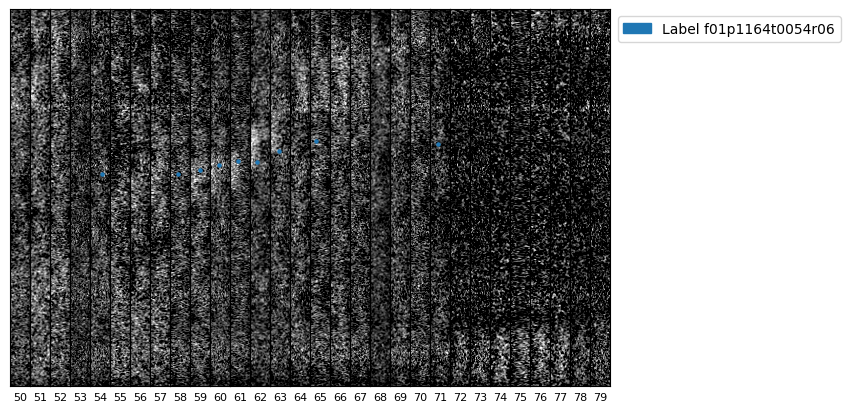

In [36]:
# Track cell 'f01p1164t0054r06'in fluorescent channel
mm3seg.display_segmentation(path_to_fluor_stack, mask_path = None, alpha = 0.5, cells_df = cell_df, start=50, end=80)

# Determine parameters for mm3seg.segment_chnl_stack

In [76]:
path_to_image = '/Users/noravivancogonzalez/Desktop/20241114/hyperstacked/drift_corrected/rotated/mm_channels/subtracted/FOV_001/region_1164/subtracted_FOV_001_region_1164_time_0061_c_0.tif'
image = tifffile.imread(path_to_image)

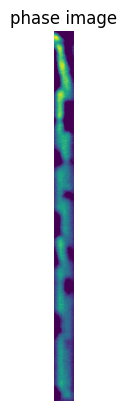

In [120]:
plt.figure()
plt.imshow(image)
plt.title('phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [80]:
from skimage.filters import threshold_otsu

In [132]:
OTSU_threshold=1.5
first_opening = 3
distance_threshold=3
second_opening_size=1
min_object_size=5
thresh = threshold_otsu(image)  # finds optimal OTSU threshhold value
threshholded = image > OTSU_threshold * thresh  # will create binary image

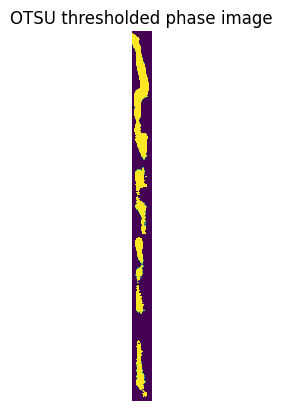

In [133]:
plt.figure()
plt.imshow(threshholded)
plt.title('OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [140]:
# Opening = erosion then dialation.
# opening smooths images, breaks isthmuses, and eliminates protrusions.
# "opens" dark gaps between bright features.
# Create a diagonal line-shaped footprint
diagonal_footprint = np.zeros((5, 5))
np.fill_diagonal(diagonal_footprint, 1)

morph = morphology.binary_opening(threshholded, diagonal_footprint)

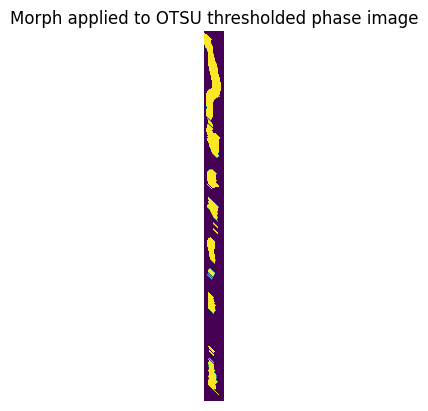

In [141]:
plt.figure()
plt.imshow(morph)
plt.title('Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [152]:
distance_threshold = 3
distance = ndi.distance_transform_edt(morph)
# threshold distance image
distance_thresh = np.zeros_like(distance)
distance_thresh[distance < distance_threshold] = 0
distance_thresh[distance >= distance_threshold] = 1

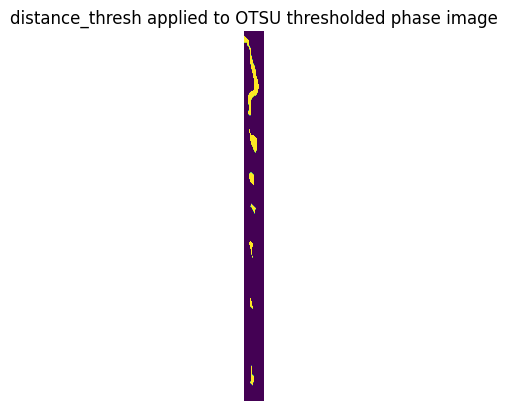

In [153]:
plt.figure()
plt.imshow(distance_thresh)
plt.title('distance_thresh applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [154]:
distance_opened = morphology.binary_opening(
        distance_thresh, morphology.disk(1)
)

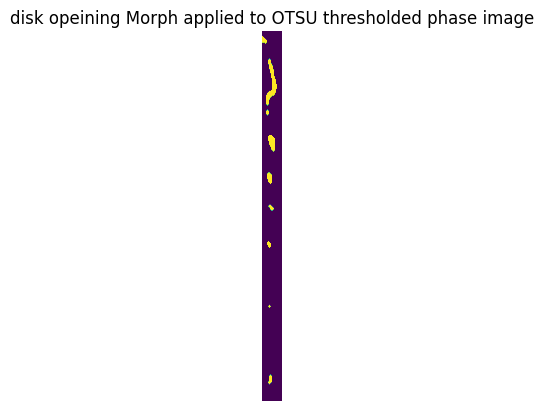

In [155]:
plt.figure()
plt.imshow(distance_opened)
plt.title('disk opeining Morph applied to OTSU thresholded phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

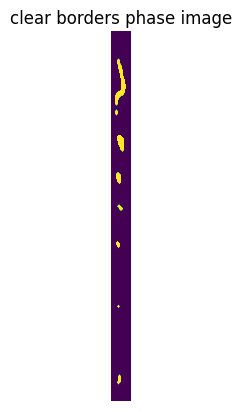

In [157]:
# remove artifacts connected to image border
cleared = segmentation.clear_border(distance_opened)
plt.figure()
plt.imshow(cleared)
plt.title('clear borders phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

In [171]:
labeled, label_num = morphology.label(cleared, connectivity=1, return_num=True)
if label_num > 1:
    labeled = morphology.remove_small_objects(labeled, min_size=5)

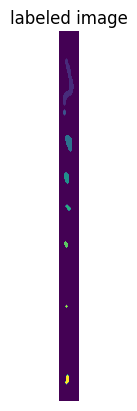

In [172]:
plt.figure()
plt.imshow(labeled)
plt.title('labeled image')
plt.axis('off')  # Hide axis labels
plt.draw()

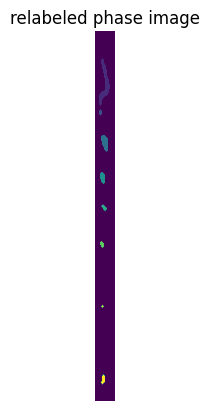

In [173]:
# relabel now that small objects and labels on edges have been cleared
markers = morphology.label(labeled, connectivity=2)
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

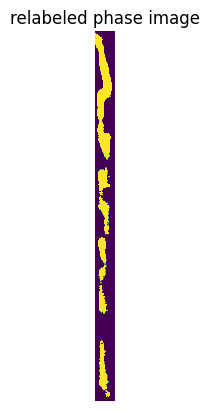

In [174]:
# the binary image for the watershed, which uses the unmodified OTSU threshold
threshholded_watershed = threshholded
plt.figure()
plt.imshow(threshholded_watershed)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

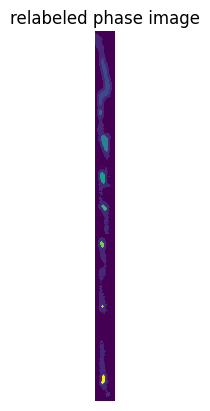

In [175]:
# set anything outside of OTSU threshold to -1 so it will not be labeled
markers[threshholded_watershed == 0] = -1
# here is the main algorithm
plt.figure()
plt.imshow(markers)
plt.title('relabeled phase image')
plt.axis('off')  # Hide axis labels
plt.draw()

/Users/noravivancogonzalez/.pyenv/versions/3.9.6/envs/napari-env/lib/python3.9/site-packages/skimage/_shared/utils.py:326: UserWarning: The probability range is outside [0, 1] given the tolerance `prob_tol`. Consider decreasing `beta` and/or decreasing `tol`.
  return func(*args, **kwargs)


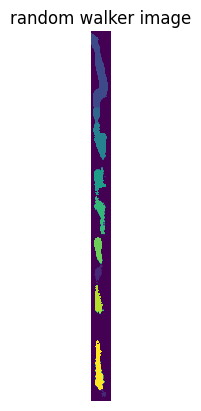

In [176]:
labeled_image = segmentation.random_walker(-1 * image, markers)
plt.figure()
plt.imshow(labeled_image)
plt.title('random walker image')
plt.axis('off')  # Hide axis labels
plt.draw()

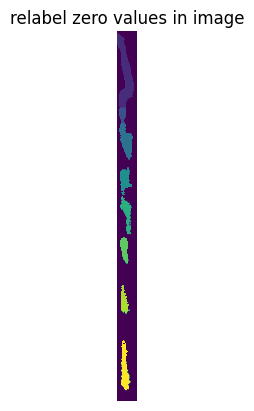

In [177]:
# put negative values back to zero for proper image
labeled_image[labeled_image == -1] = 0
plt.figure()
plt.imshow(labeled_image)
plt.title('relabel zero values in image')
plt.axis('off')  # Hide axis labels
plt.draw()